In [1]:
import pandas as pd

# Load the JSON file
df = pd.read_json('../frontend/data.json')

# Display the first few rows to verify the data
df.head()

,timestamp,PJME,Predicted_PJME,avg_temperature,is_holiday,contributors_ids
0,2017-12-07 20:00:00,36099,35082.234375,10.844858,False,"[1, 2, 3, 4, 5]"
1,2017-12-07 21:00:00,35442,34862.957031,10.614054,False,"[6, 7, 8, 9, 10]"
2,2017-12-07 22:00:00,33981,33370.074219,10.380237,False,"[11, 12, 13, 14, 15]"
3,2017-12-07 23:00:00,31624,30692.714844,10.142516,False,"[16, 17, 18, 19, 20]"
4,2017-12-08 00:00:00,29311,27927.466797,9.900000,False,"[21, 22, 23, 24, 25]"


In [2]:
# Display first and last dates
print(f"Start date: {df['timestamp'].min()}")
print(f"End date: {df['timestamp'].max()}")

Start date: 2017-12-07 20:00:00
End date: 2018-06-23 02:00:00


In [3]:
# ... existing imports and data loading ...

# Convert timestamp to datetime if it isn't already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a complete date range at hourly frequency
date_range = pd.date_range(start=df['timestamp'].min(),
                          end=df['timestamp'].max(),
                          freq='h')

# Find missing timestamps
missing_dates = date_range.difference(df['timestamp'])

print(f"Number of missing hours: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("\nFirst few missing timestamps:")
    print(missing_dates[:5])

Number of missing hours: 1479

First few missing timestamps:
DatetimeIndex(['2017-12-08 09:00:00', '2017-12-08 10:00:00',
               '2017-12-08 11:00:00', '2017-12-08 12:00:00',
               '2017-12-08 13:00:00'],
              dtype='datetime64[ns]', freq=None)


In [5]:
# Find consecutive gaps
missing_dates = pd.Series(missing_dates)  # Convert to Series for easier analysis
gaps = missing_dates.sort_values()
gaps_diff = gaps.diff()

# Find the largest gaps
largest_gaps = gaps_diff.sort_values(ascending=False).head()

print("Largest gaps in the data:")
for i, gap_size in enumerate(largest_gaps):
    idx = largest_gaps.index[i]
    gap_end = gaps[idx]
    gap_start = gaps[gaps.index.get_loc(idx) - 1] if gaps.index.get_loc(idx) > 0 else gaps.iloc[0]
    hours = gap_size.total_seconds() / 3600
    print(f"\nGap #{i+1}:")
    print(f"Size: {hours:.1f} hours")
    print(f"From: {gap_start}")
    print(f"To: {gap_end}")

Largest gaps in the data:

Gap #1:
Size: 437.0 hours
From: 2018-03-11 03:00:00
To: 2018-03-29 08:00:00

Gap #2:
Size: 375.0 hours
From: 2018-01-17 04:00:00
To: 2018-02-01 19:00:00

Gap #3:
Size: 320.0 hours
From: 2017-12-11 14:00:00
To: 2017-12-24 22:00:00

Gap #4:
Size: 278.0 hours
From: 2018-02-27 13:00:00
To: 2018-03-11 03:00:00

Gap #5:
Size: 212.0 hours
From: 2018-04-14 16:00:00
To: 2018-04-23 12:00:00


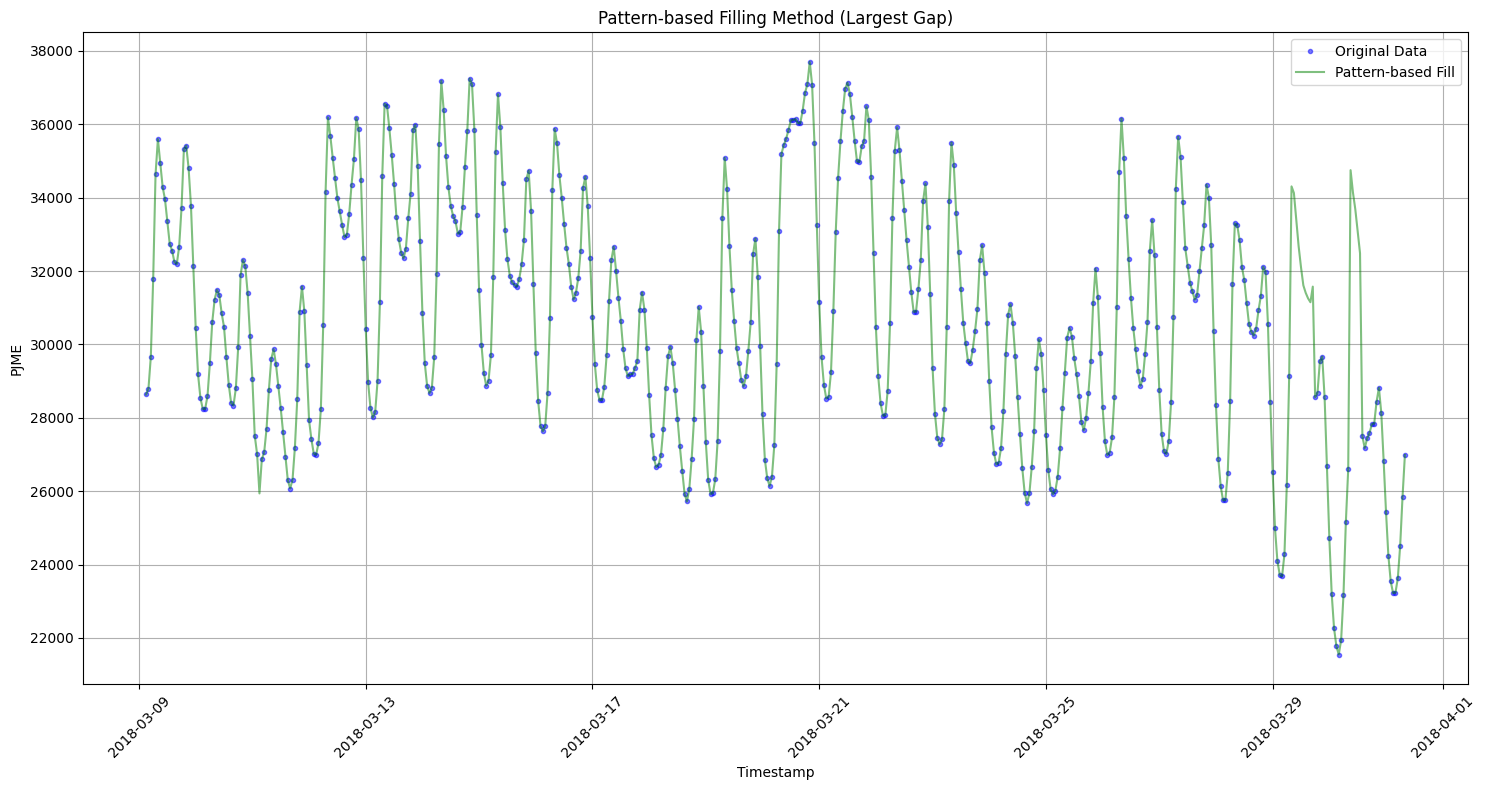

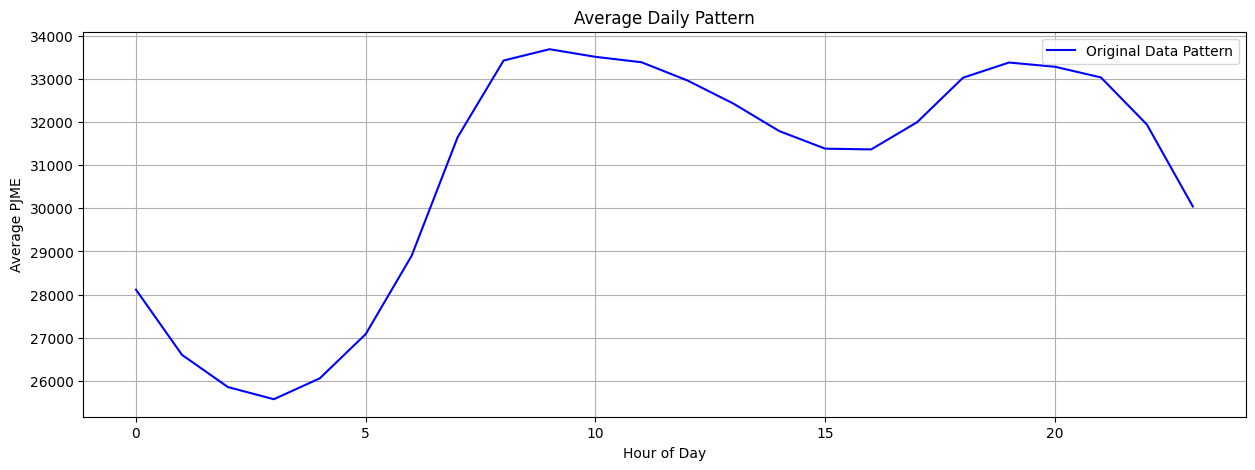

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a complete date range at hourly frequency
date_range = pd.date_range(start=df['timestamp'].min(),
                          end=df['timestamp'].max(),
                          freq='h')

# Create df_filled by reindexing original df
df_filled = df.set_index('timestamp').reindex(date_range)
df_filled = df_filled.reset_index()
df_filled = df_filled.rename(columns={'index': 'timestamp'})

# Create helper columns for pattern matching
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['dayofweek'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['month'] = pd.to_datetime(df['timestamp']).dt.month

# Calculate typical patterns
patterns = df.groupby(['month', 'dayofweek', 'hour'])[['PJME', 'Predicted_PJME', 'avg_temperature']].mean()

# Create a copy for pattern filling
df_pattern_filled = df_filled.copy()

# Create the same helper columns for df_pattern_filled
df_pattern_filled['hour'] = pd.to_datetime(df_pattern_filled['timestamp']).dt.hour
df_pattern_filled['dayofweek'] = pd.to_datetime(df_pattern_filled['timestamp']).dt.dayofweek
df_pattern_filled['month'] = pd.to_datetime(df_pattern_filled['timestamp']).dt.month

# Fill missing values using patterns
for idx in df_pattern_filled[df_pattern_filled['PJME'].isna()].index:
    month = df_pattern_filled.loc[idx, 'month']
    day = df_pattern_filled.loc[idx, 'dayofweek']
    hour = df_pattern_filled.loc[idx, 'hour']
    
    try:
        df_pattern_filled.loc[idx, 'PJME'] = patterns.loc[(month, day, hour), 'PJME']
        df_pattern_filled.loc[idx, 'Predicted_PJME'] = patterns.loc[(month, day, hour), 'Predicted_PJME']
        df_pattern_filled.loc[idx, 'avg_temperature'] = patterns.loc[(month, day, hour), 'avg_temperature']
    except KeyError:
        # If no exact pattern match, use hour-only pattern as fallback
        hour_pattern = df.groupby('hour')[['PJME', 'Predicted_PJME', 'avg_temperature']].mean()
        df_pattern_filled.loc[idx, 'PJME'] = hour_pattern.loc[hour, 'PJME']
        df_pattern_filled.loc[idx, 'Predicted_PJME'] = hour_pattern.loc[hour, 'Predicted_PJME']
        df_pattern_filled.loc[idx, 'avg_temperature'] = hour_pattern.loc[hour, 'avg_temperature']

# Let's visualize the largest gap (from our previous analysis)
gap_start = pd.Timestamp('2018-03-11 03:00:00')
gap_end = pd.Timestamp('2018-03-29 08:00:00')

# Create a window around the gap
window_start = gap_start - pd.Timedelta(days=2)
window_end = gap_end + pd.Timedelta(days=2)

# Plot both interpolation methods
plt.figure(figsize=(15, 8))

# Original data
plt.plot(df[df['timestamp'].between(window_start, window_end)]['timestamp'],
         df[df['timestamp'].between(window_start, window_end)]['PJME'],
         'b.', label='Original Data', alpha=0.5)

# Pattern-based filling
plt.plot(df_pattern_filled[df_pattern_filled['timestamp'].between(window_start, window_end)]['timestamp'],
         df_pattern_filled[df_pattern_filled['timestamp'].between(window_start, window_end)]['PJME'],
         'g-', label='Pattern-based Fill', alpha=0.5)

plt.title('Pattern-based Filling Method (Largest Gap)')
plt.xlabel('Timestamp')
plt.ylabel('PJME')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Let's also look at the daily patterns
plt.figure(figsize=(15, 5))
daily_patterns = df.groupby('hour')['PJME'].mean()
plt.plot(daily_patterns.index, daily_patterns.values, 'b-', label='Original Data Pattern')
plt.title('Average Daily Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Average PJME')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Clean up helper columns
df_pattern_filled = df_pattern_filled.drop(['hour', 'dayofweek', 'month'], axis=1)

# Add data quality flag
df_pattern_filled['data_quality'] = 'original'
df_pattern_filled.loc[df_pattern_filled.index.isin(missing_dates), 'data_quality'] = 'pattern_filled'

# Verify our filled data
print("\nVerifying filled data:")
print("Number of missing values:")
print(df_pattern_filled.isnull().sum())

# Show a sample of filled vs original data
print("\nSample of filled data (including both original and filled values):")
sample_period = df_pattern_filled[df_pattern_filled['timestamp'].between(gap_start - pd.Timedelta(hours=2), 
                                                                       gap_start + pd.Timedelta(hours=2))]
print(sample_period[['timestamp', 'PJME', 'Predicted_PJME', 'data_quality']].head(10))


Verifying filled data:
Number of missing values:
timestamp              0
PJME                   0
Predicted_PJME         0
avg_temperature        0
is_holiday          1479
contributors_ids    1479
data_quality           0
dtype: int64

Sample of filled data (including both original and filled values):
               timestamp          PJME  Predicted_PJME data_quality
2237 2018-03-11 01:00:00  27517.000000    27158.966797     original
2238 2018-03-11 02:00:00  27012.000000    26067.312500     original
2239 2018-03-11 03:00:00  25938.333333    24929.860026     original
2240 2018-03-11 04:00:00  26866.000000    26257.699219     original
2241 2018-03-11 05:00:00  27061.000000    26538.611328     original

Data saved to data_filled.json


In [9]:
from datetime import datetime
import holidays

# Get US holidays
us_holidays = holidays.US()

# Fill is_holiday
df_pattern_filled['is_holiday'] = df_pattern_filled['timestamp'].apply(
    lambda x: x in us_holidays
)

# Fill contributors_ids with empty lists
df_pattern_filled['contributors_ids'] = df_pattern_filled['contributors_ids'].fillna('[]')

# Verify the fill
print("Number of missing values after filling:")
print(df_pattern_filled.isnull().sum())

# Show a sample of the filled data
print("\nSample of filled data with holidays and contributors:")
sample_data = df_pattern_filled[['timestamp', 'PJME', 'is_holiday', 'contributors_ids']].head()
print(sample_data)

# Save the complete filled data
df_pattern_filled.to_json('../frontend/data_filled.json', orient='records')
print("\nComplete data saved to data_filled.json")

Number of missing values after filling:
timestamp           0
PJME                0
Predicted_PJME      0
avg_temperature     0
is_holiday          0
contributors_ids    0
data_quality        0
dtype: int64

Sample of filled data with holidays and contributors:
            timestamp     PJME  is_holiday      contributors_ids
0 2017-12-07 20:00:00  36099.0       False       [1, 2, 3, 4, 5]
1 2017-12-07 21:00:00  35442.0       False      [6, 7, 8, 9, 10]
2 2017-12-07 22:00:00  33981.0       False  [11, 12, 13, 14, 15]
3 2017-12-07 23:00:00  31624.0       False  [16, 17, 18, 19, 20]
4 2017-12-08 00:00:00  29311.0       False  [21, 22, 23, 24, 25]

Complete data saved to data_filled.json
